In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import os

from IPython.display import display


In [2]:
1+2

3

In [31]:
!python run_decoding.py

**********
 target/debug/decode_data std62_2048_1_6_4 CGM_p77_40D_2_3_400_h54_CGM_hourly_rolling_128_f_h54
setting parameters ...
assume: decode_data std62_2048_1_6_4 CGM_p77_40D_2_3_400_h54_CGM_hourly_rolling_128_f_h54
loading ecrypted data ...
read data/std62_2048_1_6_4/CGM_p77_40D_2_3_400_h54_CGM_hourly_rolling_128_f_h54.enc
loading secret key ... 
saving decrypted data ...
**********
 target/debug/decode_data std62_2048_1_6_4 CGM_p77_40D_2_3_400_h70_CGM_hourly_rolling_128_f_h70
setting parameters ...
assume: decode_data std62_2048_1_6_4 CGM_p77_40D_2_3_400_h70_CGM_hourly_rolling_128_f_h70
loading ecrypted data ...
read data/std62_2048_1_6_4/CGM_p77_40D_2_3_400_h70_CGM_hourly_rolling_128_f_h70.enc
loading secret key ... 
saving decrypted data ...
**********
 target/debug/decode_data std62_2048_1_6_4 CGM_p77_40D_2_3_400
setting parameters ...
assume: decode_data std62_2048_1_6_4 CGM_p77_40D_2_3_400
loading ecrypted data ...
read data/std62_2048_1_6_4/CGM_p77_40D_2_3_400.enc
loading s

In [32]:
#!target/release/encode_data 80_1024_1_6_6 CGM_p77_40D 2 3 400
#!target/release/encode_diff 80_1024_1_6_6 CGMDIFF_p77_40D 2 3 50


## score functions

In [33]:
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 TIR
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 H70
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 H54
#target/release/calc_scores 80_1024_1_6_6 CGMDIFF_p77_40D_2_3_50 RDV

#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 h70 &
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 h54 &

In [40]:
def score_GVP(dy, ceil = 2.):
    gvp = (1.0 + (dy/5.0)**2)**0.5 - 1.0
    res = np.clip(gvp, 0., ceil) # if gvp < ceil {gvp} else {ceil};
    return 100.*res


In [41]:
data = "CGM_p77_40D"
diff = "CGMDIFF"+data[3:]

df = pd.read_csv("data/%s.csv"%data, header=None, names=["ts","CGM"])
df["TIR"] = df["CGM"].apply(lambda x: 100.0 if ((x<180) & (x>70)) else 0.0)
df["H70"] = df["CGM"].apply(lambda x: 100.0 if (x<70) else 0.0)
df["H54"] = df["CGM"].apply(lambda x: 100.0 if (x<54) else 0.0)
df["h70"] = 25 + 0.5*df["H70"]
df["h54"] = 25 + 0.5*df["H54"]


df["DIFF"] = pd.read_csv("data/%s.csv"%diff, header=None, index_col=0).values
df["ABS50"] = df["DIFF"].clip(-50.,50.).apply(np.abs)
df["RDV"] = df["DIFF"].apply(lambda x: 10*score_GVP(x, 10)/100)

print(df.shape)
df.head()


(11520, 10)


,ts,CGM,TIR,H70,H54,h70,h54,DIFF,ABS50,RDV
0,2021-08-07 07:53:40,145.823333,100.0,0.0,0.0,25.0,25.0,3.658667,3.658667,2.391262
1,2021-08-07 07:58:40,152.420000,100.0,0.0,0.0,25.0,25.0,6.596667,6.596667,6.554880
2,2021-08-07 08:03:40,158.823333,100.0,0.0,0.0,25.0,25.0,6.403333,6.403333,6.248406
3,2021-08-07 08:08:40,165.823333,100.0,0.0,0.0,25.0,25.0,7.000000,7.000000,7.204651
4,2021-08-07 08:13:40,172.420000,100.0,0.0,0.0,25.0,25.0,6.596667,6.596667,6.554880


In [42]:
dfh = df.groupby(df.index//12).mean()
print(dfh.shape, len(df)/12)
dfh.head()


(960, 9) 960.0


,CGM,TIR,H70,H54,h70,h54,DIFF,ABS50,RDV
0,176.990267,50.000000,0.0,0.0,25.0,25.0,3.972684,4.754383,4.470832
1,182.215312,33.333333,0.0,0.0,25.0,25.0,-1.172549,1.172549,0.271294
2,168.144729,100.000000,0.0,0.0,25.0,25.0,-1.172549,1.172549,0.271294
3,146.342611,100.000000,0.0,0.0,25.0,25.0,-3.203698,3.962968,2.823029
4,95.301333,100.000000,0.0,0.0,25.0,25.0,-4.300000,4.300000,3.189390


In [43]:
window = 128
dfr = dfh.rolling(window).mean()
dfr = dfr.reset_index(drop=True).dropna()
print(dfr.shape)
dfr.head()


(833, 9)


,CGM,TIR,H70,H54,h70,h54,DIFF,ABS50,RDV
127,151.309790,78.776042,1.5625,0.520833,25.78125,25.260417,-0.018434,3.688908,3.464265
128,150.763772,79.166667,1.5625,0.520833,25.78125,25.260417,-0.054256,3.676298,3.447018
129,150.101304,79.687500,1.5625,0.520833,25.78125,25.260417,-0.048416,3.686972,3.460844
130,149.705035,79.687500,1.5625,0.520833,25.78125,25.260417,0.002585,3.722343,3.514271
131,149.864342,79.687500,1.5625,0.520833,25.78125,25.260417,0.032397,3.705656,3.498290


## hourly series


In [48]:
#target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400
#target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_TIR
#target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_H70
#target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_H54
#target/release/calc_hourly 80_1024_1_6_6 CGMDIFF_p77_40D_2_3_50_RDV

#target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70 &
#target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54 &


In [50]:
allfiles = glob("data/*/%s*hourly.csv"%data) + glob("data/*/%s*hourly.csv"%diff)

dth = {"CGM": {}}

for filepath in allfiles:
    _, keys, filename = filepath.split("/")
    name, _ = filename.split(".")
    tmp = name.split("_")
    tag = keys+"_"+"_".join(tmp[3:6])
    idx = "_".join(tmp[6:-1])
    if "DIFF" in name:
        idx = idx + "_DIFF"
    if idx not in dth.keys():
        dth[idx] = {}
    #print(tag, idx)
    dth[idx][tag] = pd.read_csv(filepath, header=None).values[:,0]
            
{key:len(dth[key]) for key in dth.keys()}


{'CGM': 3,
 'TIR_CGM': 3,
 'h54_CGM': 3,
 'H70_CGM': 3,
 'h70_CGM': 3,
 'H54_CGM': 3,
 'RDV_CGM_DIFF': 3,
 'ABS50_CGM_DIFF': 2}



 CGM (960, 1) (960, 3) (960, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,-0.205001,4.833823,-3.688465,-0.329742,3.037323,4.838168,160.750282,0.030097
80_1024_1_5_3_2_3_400,-0.284473,13.916384,-10.027353,-0.022512,8.833649,13.919291,160.750282,0.086590
80_1024_1_6_4_2_3_400,-0.103239,4.865852,-3.208408,-0.166338,3.281145,4.866947,160.750282,0.030276




 TIR_CGM (960, 1) (960, 3) (960, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,-0.053057,4.162275,-0.892811,0.0,0.510185,4.162613,66.623264,0.062480
80_1024_1_5_3_2_3_400,-0.484717,6.955995,-2.915736,0.0,1.292950,6.972863,66.623264,0.104661
80_1024_1_6_4_2_3_400,-0.110405,4.155178,-0.893942,0.0,0.502962,4.156645,66.623264,0.062390




 h54_CGM (960, 1) (960, 3) (960, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.075912,1.284946,-0.765314,0.127528,0.892842,1.287186,25.212674,0.051053
std62_2048_1_6_4_2_3_400,0.006209,0.930834,-0.573076,0.054171,0.574692,0.930855,25.212674,0.036920
80_1024_1_6_4_2_3_400,0.024177,1.254248,-0.767500,0.000073,0.888041,1.254481,25.212674,0.049756




 H70_CGM (960, 1) (960, 3) (960, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,1.023112,2.055393,0.127545,0.892862,1.530623,2.295953,1.475694,1.555846
80_1024_1_5_3_2_3_400,2.698736,3.432088,0.262063,2.111574,4.399018,4.366051,1.475694,2.958642
80_1024_1_6_4_2_3_400,0.967670,2.038585,0.129595,0.888721,1.530987,2.256594,1.475694,1.529174




 h70_CGM (960, 1) (960, 3) (960, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.017495,1.547925,-0.892856,0.000023,0.765336,1.548024,25.737847,0.060146
std62_2048_1_6_4_2_3_400,0.069576,1.121288,-0.516204,0.061697,0.649881,1.123445,25.737847,0.043650
80_1024_1_6_4_2_3_400,-0.016282,1.553751,-0.890367,0.004086,0.766318,1.553836,25.737847,0.060372




 H54_CGM (960, 1) (960, 3) (960, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,1.012128,1.217255,0.127592,0.765354,1.530611,1.583071,0.425347,3.721831
80_1024_1_5_3_2_3_400,2.705372,4.358417,0.233677,2.053772,3.964049,5.129799,0.425347,12.060262
80_1024_1_6_4_2_3_400,0.965584,1.086132,0.128714,0.765359,1.532345,1.453284,0.425347,3.416701




 RDV_CGM_DIFF (960, 1) (960, 3) (960, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_50,0.362306,1.156916,-0.428979,0.348290,1.131415,1.212320,2.972226,0.407883
80_1024_1_5_3_2_3_50,1.422862,3.087045,-0.652690,1.012307,3.396018,3.399173,2.972226,1.143646
80_1024_1_6_4_2_3_50,0.352410,1.153424,-0.397150,0.337996,1.135684,1.206060,2.972226,0.405777




 ABS50_CGM_DIFF (960, 1) (960, 2) (960, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_5_3_2_3_50,0.338957,1.673260,-0.818173,0.273283,1.40052,1.707247,3.320354,0.514176
80_1024_1_6_4_2_3_50,0.123957,0.642235,-0.302464,0.155209,0.56944,0.654088,3.320354,0.196993


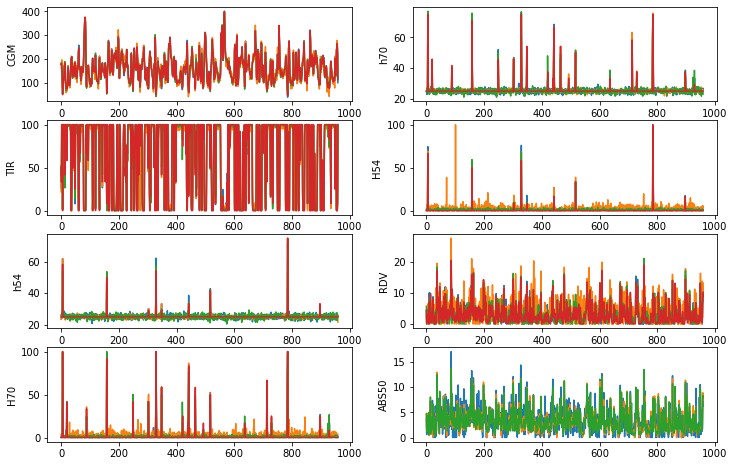

In [59]:
fig, axs = plt.subplots(4,2, figsize=(12, 8))
for i, idx in enumerate(dth.keys()):
    nom = idx.split("_")[0]
    axs[i%4,i//4].set_ylabel(nom)
    tmp = pd.DataFrame(dth[idx], index=None)
    axs[i%4,i//4].plot(tmp)
    tst = dfh[[nom]]
    axs[i%4,i//4].plot(tst)
    err = tmp - tst.values
    #axs[i%3,i//3].plot(err)
    print("\n\n", idx, tst.shape, tmp.shape, err.shape)       
    stats = err.describe().T[["mean","std","25%","50%","75%"]]
    stats["rmse"] = (stats["mean"]**2 + stats["std"]**2)**0.5
    stats["avg"] = tst.mean()[0]
    stats["rel"] = stats["rmse"]/stats["avg"]
    display(stats)
plt.show()


## rolling series


In [60]:
#target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_CGM_hourly 128
#target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_H70_CGM_hourly 128
#target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_TIR_CGM_hourly 128 &
#target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_H54_CGM_hourly 128 &
#target/release/calc_rolling 80_1024_1_6_6 CGMDIFF_p77_40D_2_3_50_RDV_CGM_hourly 128 &

#target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70_CGM_hourly 128 &
#target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54_CGM_hourly 128 &

In [61]:
allfiles = glob("data/*/%s*hourly_rolling_128.csv"%data) + glob("data/*/%s*hourly_rolling_128.csv"%diff)

dtr = {}

for filepath in allfiles:
    _, keys, filename = filepath.split("/")
    name, _ = filename.split(".")
    tmp = name.split("_")
    tag = keys+"_"+"_".join(tmp[3:6])
    if "1_5_3_2_3" in tag:
        continue
    idx = "_".join(tmp[6:-1])
    if "DIFF" in name:
        idx = idx + "_DIFF"
    if idx not in dtr.keys():
        dtr[idx] = {}
    print(idx, tag)
    dtr[idx][tag] = pd.read_csv(filepath, header=None).values[:,0]
            
{key:len(dtr[key]) for key in dtr.keys()}


CGM_hourly_rolling 80_1024_1_6_6_2_3_400
TIR_CGM_hourly_rolling 80_1024_1_6_6_2_3_400
h70_CGM_hourly_rolling 80_1024_1_6_6_2_3_400
h54_CGM_hourly_rolling 80_1024_1_6_6_2_3_400
H54_CGM_hourly_rolling 80_1024_1_6_6_2_3_400
H70_CGM_hourly_rolling 80_1024_1_6_6_2_3_400
h70_CGM_hourly_rolling std62_2048_1_6_4_2_3_400
h54_CGM_hourly_rolling std62_2048_1_6_4_2_3_400
CGM_hourly_rolling 80_1024_1_6_4_2_3_400
TIR_CGM_hourly_rolling 80_1024_1_6_4_2_3_400
h70_CGM_hourly_rolling 80_1024_1_6_4_2_3_400
h54_CGM_hourly_rolling 80_1024_1_6_4_2_3_400
H54_CGM_hourly_rolling 80_1024_1_6_4_2_3_400
H70_CGM_hourly_rolling 80_1024_1_6_4_2_3_400
RDV_CGM_hourly_rolling_DIFF 80_1024_1_6_6_2_3_50
RDV_CGM_hourly_rolling_DIFF 80_1024_1_6_4_2_3_50
ABS50_CGM_hourly_rolling_DIFF 80_1024_1_6_4_2_3_50


{'CGM_hourly_rolling': 2,
 'TIR_CGM_hourly_rolling': 2,
 'h70_CGM_hourly_rolling': 3,
 'h54_CGM_hourly_rolling': 3,
 'H54_CGM_hourly_rolling': 2,
 'H70_CGM_hourly_rolling': 2,
 'RDV_CGM_hourly_rolling_DIFF': 2,
 'ABS50_CGM_hourly_rolling_DIFF': 1}



 CGM_hourly_rolling (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.513198,4.176745,-2.086416,0.560850,3.259175,4.208155,162.403218,0.025912
80_1024_1_6_4_2_3_400,0.007227,3.974512,-2.592521,0.134483,2.370247,3.974519,162.403218,0.024473




 TIR_CGM_hourly_rolling (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.223492,1.006851,-0.492929,0.139538,0.976535,1.031358,65.712613,0.015695
80_1024_1_6_4_2_3_400,-0.003162,1.082603,-0.773230,0.038486,0.738521,1.082608,65.712613,0.016475




 h70_CGM_hourly_rolling (833, 1) (833, 3) (833, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.116514,1.111896,-0.585948,0.092974,0.911479,1.117984,25.73588,0.043441
std62_2048_1_6_4_2_3_400,0.130636,0.713828,-0.354467,0.133542,0.637972,0.725683,25.73588,0.028197
80_1024_1_6_4_2_3_400,-0.079886,1.105237,-0.808192,-0.122792,0.681899,1.108120,25.73588,0.043057




 h54_CGM_hourly_rolling (833, 1) (833, 3) (833, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.066219,0.915720,-0.558000,0.037184,0.716153,0.918111,25.201878,0.036430
std62_2048_1_6_4_2_3_400,0.120440,0.752960,-0.392096,0.146748,0.648253,0.762531,25.201878,0.030257
80_1024_1_6_4_2_3_400,0.471573,0.920774,-0.129637,0.500488,1.126720,1.034508,25.201878,0.041049




 H54_CGM_hourly_rolling (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,1.039368,0.959612,0.297600,0.920758,1.729897,1.414617,0.403755,3.503650
80_1024_1_6_4_2_3_400,1.199301,0.839621,0.559237,1.228432,1.755945,1.463997,0.403755,3.625951




 H70_CGM_hourly_rolling (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,1.367456,0.920975,0.734737,1.376522,1.981026,1.648675,1.471761,1.120206
80_1024_1_6_4_2_3_400,1.035064,0.911086,0.462932,1.043225,1.688320,1.378925,1.471761,0.936922




 RDV_CGM_hourly_rolling_DIFF (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_50,0.368104,0.896197,-0.239902,0.352870,0.948868,0.968850,2.951037,0.328308
80_1024_1_6_4_2_3_50,0.328244,0.992511,-0.376271,0.346256,1.029506,1.045381,2.951037,0.354242




 ABS50_CGM_hourly_rolling_DIFF (833, 1) (833, 1) (833, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_50,0.008525,0.466953,-0.306558,0.000046,0.320107,0.467031,3.317866,0.140763


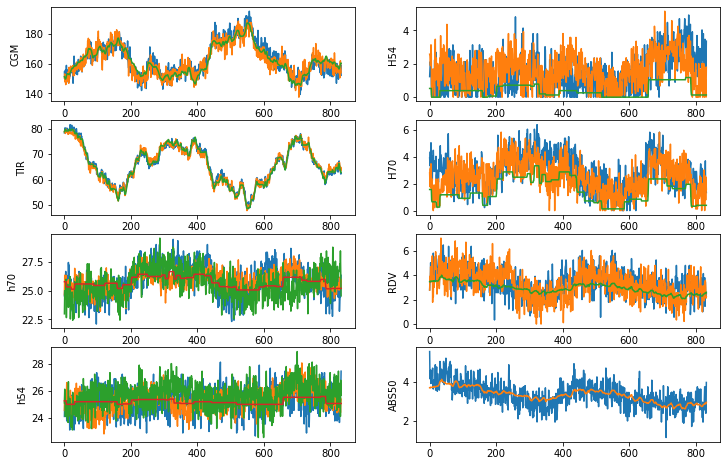

In [62]:
fig, axs = plt.subplots(4,2, figsize=(12, 8))
for i, idx in enumerate(dtr.keys()):
    nom = idx.split("_")[0]
    axs[i%4,i//4].set_ylabel(nom)
    tmp = pd.DataFrame(dtr[idx], index=None)
    axs[i%4,i//4].plot(tmp)
    tst = dfr[[nom]].reset_index(drop=True)
    axs[i%4,i//4].plot(tst)
    err = tmp - tst.values
    #axs[i%3,i//3].plot(err)
    print("\n\n", idx, tst.shape, tmp.shape, err.shape)  
    stats = err.describe().T[["mean","std","25%","50%","75%"]]
    stats["rmse"] = (stats["mean"]**2 + stats["std"]**2)**0.5
    stats["avg"] = tst.mean()[0]
    stats["rel"] = stats["rmse"]/stats["avg"]
    display(stats)
plt.show()


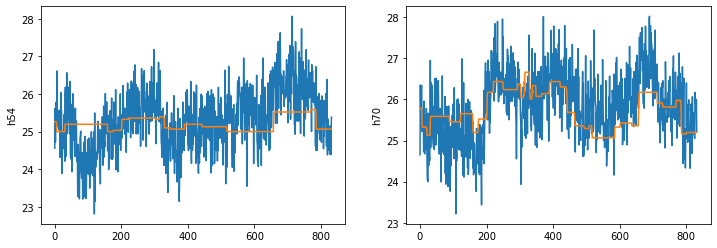

In [71]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
for i, idx in enumerate(["h54_CGM_hourly_rolling","h70_CGM_hourly_rolling"]):
    nom = idx.split("_")[0]
    axs[i].set_ylabel(nom)
    tmp = pd.DataFrame(dtr[idx], index=None)
    tmp = tmp[["std62_2048_1_6_4_2_3_400"]]
    axs[i].plot(tmp)
    tst = dfr[[nom]].reset_index(drop=True)
    axs[i].plot(tst)
plt.show()


## Personal Glycemic Score


In [63]:
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_H54_CGM_hourly_rolling_128 f_H54 &
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_H70_CGM_hourly_rolling_128 f_H70 &
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_TIR_CGM_hourly_rolling_128 f_PTIR &
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_CGM_hourly_rolling_128 f_MG &
#target/release/calc_scores 80_1024_1_6_6 CGMDIFF_p77_40D_2_3_50_RDV_CGM_hourly_rolling_128 f_GVP &

#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54_CGM_hourly_rolling_128 f_H54 &
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70_CGM_hourly_rolling_128 f_H70 &

In [64]:
#target/release/calc_aggPGS 80_1024_1_6_6 # CGM_p77_40D_2_3_400 CGMDIFF_p77_40D_2_3_50


In [65]:
def f_H54(x):
     return 0.5 + 4.5*(1-np.exp(-0.81093*x))
        
def f_H70(x):
    c = 1.0*(x <= 7.65)
    return c*(0.625 + 0.5714*x) + (1-c)*5.0
    
def f_GVP(x):
    return 1. + 9/(1.+np.exp(-0.049*(x-65.47)))

def f_PTIR(x):
    return 1. + 9/(1.+np.exp(0.0833*(x-55.05)))

def f_MG(x):
    return 1. + 9/(1.+np.exp(0.1139*(x-72.08))) + 9/(1.+np.exp(-0.09195*(x-157.57)))


(833, 9)


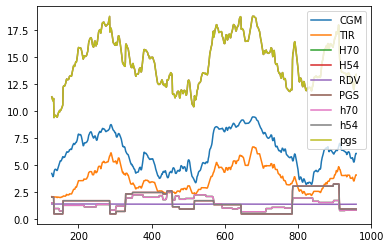

,CGM,TIR,H70,H54,RDV,PGS,h70,h54,pgs
127,4.240540,2.095348,1.517813,2.050257,1.411535,11.315493,1.517813,2.050257,11.315493
128,4.137258,2.064428,1.517813,2.050257,1.411203,11.180959,1.517813,2.050257,11.180959
129,4.014059,2.024378,1.517813,2.050257,1.411469,11.017976,1.517813,2.050257,11.017976
130,3.941532,2.024378,1.517813,2.050257,1.412498,10.946478,1.517813,2.050257,10.946478
131,3.970581,2.024378,1.517813,2.050257,1.412190,10.975219,1.517813,2.050257,10.975219


In [66]:
dff = dfr[['CGM', 'TIR', 'H70', 'H54', 'RDV']].copy()
dff["CGM"] = dff["CGM"].apply(f_MG)
dff["TIR"] = dff["TIR"].apply(f_PTIR)
dff["H70"] = dff["H70"].apply(f_H70)
dff["H54"] = dff["H54"].apply(f_H54)
dff["RDV"] = dff["RDV"].apply(f_GVP)
dff["PGS"] = dff.sum(axis=1)
dff["h70"] = dff["H70"]
dff["h54"] = dff["H54"]
dff["pgs"] = dff["PGS"]
print(dff.shape)
dff.plot()
plt.show()
dff.head()


In [67]:
allfiles = glob("data/*/%s*hourly_rolling_128_f*.csv"%data) + glob("data/*/%s*hourly_rolling_128_f*.csv"%diff)

dtf = {}

for filepath in allfiles:
    _, keys, filename = filepath.split("/")
    name, _ = filename.split(".")
    tmp = name.split("_")
    tag = keys+"_"+"_".join(tmp[3:6])
    if "1_5_3_2_3" in tag:
        continue
    idx = "_".join(tmp[6:-1])
    if "DIFF" in name:
        idx = idx + "_DIFF"
    if idx not in dtf.keys():
        dtf[idx] = {}
    print(tag, idx)
    dtf[idx][tag] = pd.read_csv(filepath, header=None).values[:,0]
            
{key:len(dtf[key]) for key in dtf.keys()}


80_1024_1_6_6_2_3_400 H54_CGM_hourly_rolling_128_f
80_1024_1_6_6_2_3_400 h54_CGM_hourly_rolling_128_f
80_1024_1_6_6_2_3_400and50 PGS_hourly_rolling_128_f
80_1024_1_6_6_2_3_400 H70_CGM_hourly_rolling_128_f
80_1024_1_6_6_2_3_400 h70_CGM_hourly_rolling_128_f
80_1024_1_6_6_2_3_400 h54_CGM_hourly_rolling_128_f
80_1024_1_6_6_2_3_400 CGM_hourly_rolling_128_f
80_1024_1_6_6_2_3_400 TIR_CGM_hourly_rolling_128_f
80_1024_1_6_6_2_3_400and50 PGS_hourly_rolling_128_f
80_1024_1_6_6_2_3_400 h70_CGM_hourly_rolling_128_f
std62_2048_1_6_4_2_3_400 h54_CGM_hourly_rolling_128_f
std62_2048_1_6_4_2_3_400 h70_CGM_hourly_rolling_128_f
80_1024_1_6_4_2_3_400 H54_CGM_hourly_rolling_128_f
80_1024_1_6_4_2_3_400and50 PGS_hourly_rolling_128_f
80_1024_1_6_4_2_3_400 H70_CGM_hourly_rolling_128_f
80_1024_1_6_4_2_3_400 h54_CGM_hourly_rolling_128_f
80_1024_1_6_4_2_3_400 CGM_hourly_rolling_128_f
80_1024_1_6_4_2_3_400 TIR_CGM_hourly_rolling_128_f
80_1024_1_6_4_2_3_400and50 PGS_hourly_rolling_128_f
80_1024_1_6_4_2_3_400 h70_CGM

{'H54_CGM_hourly_rolling_128_f': 2,
 'h54_CGM_hourly_rolling_128_f': 3,
 'PGS_hourly_rolling_128_f': 2,
 'H70_CGM_hourly_rolling_128_f': 2,
 'h70_CGM_hourly_rolling_128_f': 3,
 'CGM_hourly_rolling_128_f': 2,
 'TIR_CGM_hourly_rolling_128_f': 2,
 'RDV_CGM_hourly_rolling_128_f_DIFF': 2}



 H54_CGM_hourly_rolling_128_f (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,1.427690,1.455004,0.414616,1.615421,2.472129,2.038464,1.624347,1.254943
80_1024_1_6_4_2_3_400,1.666515,1.379558,0.776161,1.801552,2.749524,2.163436,1.624347,1.331880




 h54_CGM_hourly_rolling_128_f (833, 1) (833, 3) (833, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.551084,2.085741,-0.950929,0.510128,2.318455,2.157315,1.624347,1.328112
std62_2048_1_6_4_2_3_400,0.485213,1.832536,-1.100179,0.416265,1.848212,1.895685,1.624347,1.167044
80_1024_1_6_4_2_3_400,1.100430,2.037899,-0.500000,1.596338,2.760885,2.316027,1.624347,1.425820




 PGS_hourly_rolling_128_f (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400and50,2.223441,1.856880,0.956350,2.275327,3.621152,2.896842,14.562818,0.198920
80_1024_1_6_4_2_3_400and50,2.196946,1.705635,1.062541,2.380216,3.433469,2.781324,14.562818,0.190988




 H70_CGM_hourly_rolling_128_f (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.785422,0.675884,0.286976,0.786525,1.243560,1.036198,1.465964,0.706837
80_1024_1_6_4_2_3_400,0.579319,0.659006,0.100992,0.605960,1.057487,0.877440,1.465964,0.598541




 h70_CGM_hourly_rolling_128_f (833, 1) (833, 3) (833, 3)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.220717,1.251437,-0.829038,0.026570,1.089441,1.270752,1.465964,0.866837
std62_2048_1_6_4_2_3_400,0.156201,0.938346,-0.584930,0.127487,0.791191,0.951258,1.465964,0.648896
80_1024_1_6_4_2_3_400,0.096324,1.220114,-0.871607,-0.122186,0.946109,1.223910,1.465964,0.834884




 CGM_hourly_rolling_128_f (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,0.049992,0.878180,-0.495698,0.068331,0.593045,0.879601,6.307079,0.139463
80_1024_1_6_4_2_3_400,-0.052608,0.869706,-0.555167,-0.022985,0.468622,0.871296,6.307079,0.138146




 TIR_CGM_hourly_rolling_128_f (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_400,-0.048020,0.196337,-0.174621,-0.025738,0.078412,0.202124,3.763579,0.053705
80_1024_1_6_4_2_3_400,-0.002891,0.192453,-0.118708,0.003981,0.116026,0.192474,3.763579,0.051141




 RDV_CGM_hourly_rolling_128_f_DIFF (833, 1) (833, 2) (833, 2)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_6_2_3_50,0.007828,0.022408,-0.007748,0.006591,0.022827,0.023736,1.401848,0.016932
80_1024_1_6_4_2_3_50,0.007274,0.023636,-0.009998,0.006823,0.022475,0.024730,1.401848,0.017641


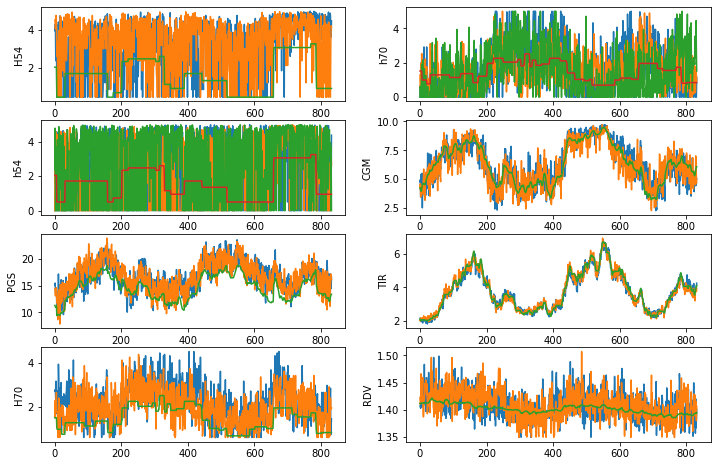

In [68]:
fig, axs = plt.subplots(4,2, figsize=(12, 8))
for i, idx in enumerate(dtf.keys()):
    nom = idx.split("_")[0]
    axs[i%4,i//4].set_ylabel(nom)
    tmp = pd.DataFrame(dtf[idx], index=None)
    axs[i%4,i//4].plot(tmp)
    tst = dff[[nom]].reset_index(drop=True)
    axs[i%4,i//4].plot(tst)
    err = tmp - tst.values
    #axs[i%3,i//3].plot(err)
    print("\n\n", idx, tst.shape, tmp.shape, err.shape)  
    stats = err.describe().T[["mean","std","25%","50%","75%"]]
    stats["rmse"] = (stats["mean"]**2 + stats["std"]**2)**0.5
    stats["avg"] = tst.mean()[0]
    stats["rel"] = stats["rmse"]/stats["avg"]
    display(stats)
plt.show()


     count      mean      std       min      25%       50%       75%       max
PGS  833.0  2.223441  1.85688 -3.973014  0.95635  2.275327  3.621152  7.572116
     count      mean       std       min       25%       50%       75%  \
pgs  833.0  0.277269  2.532873 -6.630295 -1.497795  0.063392  1.973975   

          max  
pgs  7.907725  


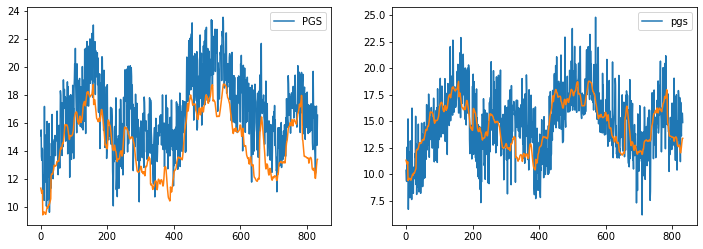

In [22]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
tmp = pd.read_csv("data/80_1024_1_6_6/CGM_p77_40D_2_3_400and50_PGS_hourly_rolling_128_f_PGS.csv", names=["PGS"])
tmp.plot(ax=axs[0])
tst = dff["PGS"].reset_index(drop=True)
tst.plot(ax=axs[0])
print((tmp - tst.values[:,None]).describe().T)
tmp = pd.read_csv("data/80_1024_1_6_6/CGM_p77_40D_2_3_400and50_PGS_hourly_rolling_128_f_pgs.csv", names=["pgs"])
tmp.plot(ax=axs[1])
tst = dff["pgs"].reset_index(drop=True)
tst.plot(ax=axs[1])
print((tmp - tst.values[:,None]).describe().T)
plt.show()


     count      mean       std       min       25%       50%       75%  \
PGS  833.0  2.196946  1.705635 -2.277905  1.062541  2.380216  3.433469   

          max  
PGS  6.544224  
     count      mean       std       min       25%       50%       75%  \
pgs  833.0  1.153421  2.534741 -5.760034 -0.741523  1.286174  3.097308   

          max  
pgs  8.157398  


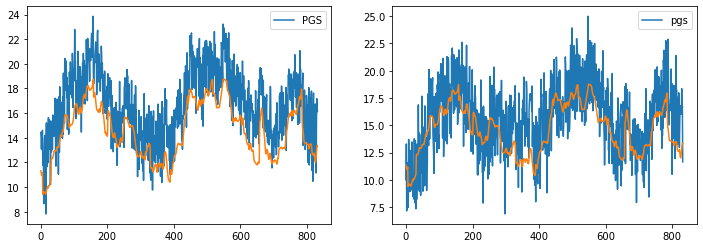

In [28]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
tmp = pd.read_csv("data/80_1024_1_6_4/CGM_p77_40D_2_3_400and50_PGS_hourly_rolling_128_f_PGS.csv", names=["PGS"])
tmp.plot(ax=axs[0])
tst = dff["PGS"].reset_index(drop=True)
tst.plot(ax=axs[0])
print((tmp - tst.values[:,None]).describe().T)
tmp = pd.read_csv("data/80_1024_1_6_4/CGM_p77_40D_2_3_400and50_PGS_hourly_rolling_128_f_pgs.csv", names=["pgs"])
tmp.plot(ax=axs[1])
tst = dff["pgs"].reset_index(drop=True)
tst.plot(ax=axs[1])
print((tmp - tst.values[:,None]).describe().T)
plt.show()


In [23]:
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 h70 &
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 h54 &

#target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70 &
#target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54 &

#target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70_CGM_hourly 128 &
#target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54_CGM_hourly 128 &

#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54_CGM_hourly_rolling_128 f_H54 &
#target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70_CGM_hourly_rolling_128 f_H70 &

In [24]:
#target/release/calc_aggPGS 80_1024_1_6_6 # CGM_p77_40D_2_3_400 CGMDIFF_p77_40D_2_3_50


In [30]:
print("""
target/release/encode_data 80_1024_1_6_6 CGM_p77_40D 2 3 400
target/release/encode_diff 80_1024_1_6_6 CGMDIFF_p77_40D 2 3 50

target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 h70 &&
target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70 &&
target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70_CGM_hourly 128 &&
target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_h70_CGM_hourly_rolling_128 f_h70

target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400 h54 &&
target/release/calc_hourly 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54 && 
target/release/calc_rolling 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54_CGM_hourly 128 &&
target/release/calc_scores 80_1024_1_6_6 CGM_p77_40D_2_3_400_h54_CGM_hourly_rolling_128 f_h54

target/release/calc_aggPGS_2 80_1024_1_6_6
""".replace("80_1024_1_6_6","std62_2048_1_6_4"))



target/release/encode_data std62_2048_1_6_4 CGM_p77_40D 2 3 400
target/release/encode_diff std62_2048_1_6_4 CGMDIFF_p77_40D 2 3 50

target/release/calc_scores std62_2048_1_6_4 CGM_p77_40D_2_3_400 h70 &&
target/release/calc_hourly std62_2048_1_6_4 CGM_p77_40D_2_3_400_h70 &&
target/release/calc_rolling std62_2048_1_6_4 CGM_p77_40D_2_3_400_h70_CGM_hourly 128 &&
target/release/calc_scores std62_2048_1_6_4 CGM_p77_40D_2_3_400_h70_CGM_hourly_rolling_128 f_h70

target/release/calc_scores std62_2048_1_6_4 CGM_p77_40D_2_3_400 h54 &&
target/release/calc_hourly std62_2048_1_6_4 CGM_p77_40D_2_3_400_h54 && 
target/release/calc_rolling std62_2048_1_6_4 CGM_p77_40D_2_3_400_h54_CGM_hourly 128 &&
target/release/calc_scores std62_2048_1_6_4 CGM_p77_40D_2_3_400_h54_CGM_hourly_rolling_128 f_h54

target/release/calc_aggPGS_2 std62_2048_1_6_4



In [26]:
#target/release/encode_data 80_1024_1_6_6 CGM_p77_40D 2 3 400
#!target/release/encode_diff 80_1024_1_6_6 CGMDIFF_p77_40D 2 3 50